In [1]:
import numpy as np
from scipy.special import gamma
import matplotlib.pyplot as plt

In [2]:
def normalization_Student(d, dof, shape):
    return (gamma(dof/2) * ((dof * np.pi)**(d/2)) * np.sqrt(np.linalg.det(shape)) ) / gamma((dof+d)/2)

In [47]:
def alpha_entropy_p(d, dof_p, shape_p, dof):
    alpha = 1 + 2 / (dof + d)
    dof_alpha = dof_p + 2 * (dof_p + d) / (dof + d)
    shape_alpha = (dof_p / dof_alpha) * shape_p
    
    return -0.5*(dof+d)*(np.log(normalization_Student(d, dof_alpha, shape_alpha)) - alpha*np.log(normalization_Student(d,dof_p,shape_p)))

In [67]:
def optimal_Renyi(d, dof_target, shape_target, dof_approx):
    alpha = 1 + 2 / (dof_approx + d)
    dof_alpha = dof_target + 2 * (dof_target + d) / (dof_approx + d)
    shape_alpha = (dof_target / dof_alpha) * shape_target
    shape_approx = (dof_target / (dof_alpha - 2))*shape_target
    
    alpha_entropy_target = alpha_entropy_p(d, dof_target, shape_target, dof_approx)
    alpha_entropy_proposal = alpha_entropy_p(d, dof_approx, shape_approx, dof_approx)
    return alpha_entropy_proposal - alpha_entropy_target

In [68]:
def matrix_condition(d,cond):
    #returns a symmetric positive definite matrix of size d with condition number cond
    y = np.random.uniform(-1,1,d)
    Y = np.eye(d) - ( 2 / sum(y**2) )*np.outer(y,y)
    D = np.diag([ np.exp( (i/(d-1)) * np.log(cond)) for i in range(d)])
    return Y @ D @ Y

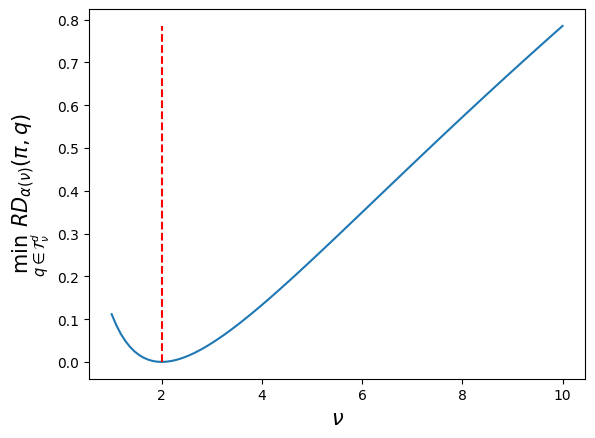

In [91]:
d = 5
shape_target = matrix_condition(d,10)
dof_target = 2
nb_dof_test = 100

dof_prop_test = np.linspace(1, 10, nb_dof_test)
res = []
for i in range(nb_dof_test):
    res.append(optimal_Renyi(d, dof_target, shape_target, dof_prop_test[i]))

plt.plot(dof_prop_test, res)
plt.vlines(dof_target, ymin = 0.0, ymax = res[nb_dof_test-1], color='red', linestyle='--')
plt.xlabel(r'$ \nu $', fontsize=15)
plt.ylabel(r'$ \min_{q \in \mathcal{T}_{\nu}^d}\; RD_{\alpha(\nu)}(\pi, q) $', fontsize = 15)
plt.show()